# Pokémon GO attack party optimization
Helper functions and static data:

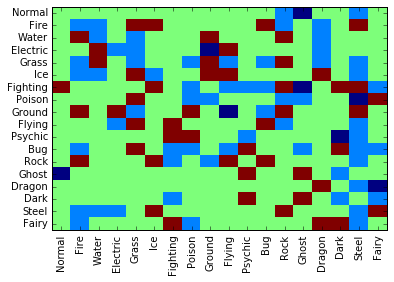

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

def read_csv(data, **kwargs):
    """Read CSV from a string."""
    return pd.read_csv(StringIO(data), delim_whitespace=True, **kwargs)

def show_heatmap(df):
    """Display data in dataframe df as a heatmap."""
    plt.pcolor(df)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    plt.gca().invert_yaxis()
    plt.show()

# Pokémon types
types = read_csv("""
           Type1    Type2
Aerodactyl Rock     Flying
Arbok      Poison   -
Arcanine   Fire     -
Charizard  Fire     Flying
Electabuzz Electric -
Flareon    Fire     -
Golduck    Water    -
Golem      Rock     Ground
Jynx       Psychic  Ice
Machoke    Fighting -
Magmar     Fire     -
Parasect   Bug      Grass
Pidgeot    Flying   Normal
Ponyta     Fire     -
Primeape   Fighting -
Rhydon     Ground   Rock
Sandslash  Ground   -
Snorlax    Normal   -
Vaporeon   Water    -
""", index_col=0)

# Data from http://pokemondb.net/type split into two tables for readability
data1 = read_csv("""
         Normal Fire Water Electric Grass Ice Fighting Poison Ground
Normal     -     -     -      -       -    -     -       -      -   
Fire       -    0.5   0.5     -       2    2     -       -      -   
Water      -     2    0.5     -      0.5   -     -       -      2   
Electric   -     -     2     0.5     0.5   -     -       -      0   
Grass      -    0.5    2      -      0.5   -     -      0.5     2   
Ice        -    0.5   0.5     -       2   0.5    -       -      2   
Fighting   2     -     -      -       -    2     -      0.5     -   
Poison     -     -     -      -       2    -     -      0.5    0.5  
Ground     -     2     -      2      0.5   -     -       2      -   
Flying     -     -     -     0.5      2    -     2       -      -   
Psychic    -     -     -      -       -    -     2       2      -   
Bug        -    0.5    -      -       2    -    0.5     0.5     -   
Rock       -     2     -      -       -    2    0.5      -     0.5  
Ghost      0     -     -      -       -    -     -       -      -   
Dragon     -     -     -      -       -    -     -       -      -   
Dark       -     -     -      -       -    -    0.5      -      -   
Steel      -    0.5   0.5    0.5      -    2     -       -      -   
Fairy      -    0.5    -      -       -    -     2      0.5     -   
""")

data2 = read_csv("""
         Flying Psychic Bug Rock Ghost Dragon Dark Steel Fairy
Normal     -       -     -   0.5   0     -     -    0.5    -  
Fire       -       -     2   0.5   -    0.5    -     2     -  
Water      -       -     -    2    -    0.5    -     -     -  
Electric   2       -     -    -    -    0.5    -     -     -  
Grass     0.5      -    0.5   2    -    0.5    -    0.5    -  
Ice        2       -     -    -    -     2     -    0.5    -  
Fighting  0.5     0.5   0.5   2    0     -     2     2    0.5 
Poison     -       -     -   0.5  0.5    -     -     0     2  
Ground     0       -    0.5   2    -     -     -     2     -  
Flying     -       -     2   0.5   -     -     -    0.5    -  
Psychic    -      0.5    -    -    -     -     0    0.5    -  
Bug       0.5      2     -    -   0.5    -     2    0.5   0.5 
Rock       2       -     2    -    -     -     -    0.5    -  
Ghost      -       2     -    -    2     -    0.5    -     -  
Dragon     -       -     -    -    -     2     -    0.5    0  
Dark       -       2     -    -    2     -    0.5    -    0.5 
Steel      -       -     -    2    -     -     -    0.5    2  
Fairy      -       -     -    -    -     2     2    0.5    -
""")

# damage_factor[i, j] is the damage multiplier for attack of type i on Pokémon of type j
damage_factor = pd.concat([data1, data2], axis=1).replace('-', 1.0)
damage_factor = damage_factor.apply(pd.to_numeric, errors='coerce')

# Fraction of special attacks (Attack2), e.g. 0.1 means that 10% of attacks
# are special.
attack2_fraction = 0.1

def estimate_damage(my, enemy):
    """Estimate average damage that my Pokémon inflicts on the enemy Pokémon."""
    type1, type2 = types.loc[enemy.Pokemon]
    adv1 = damage_factor.loc[my.Attack1][type1]
    adv2 = damage_factor.loc[my.Attack2][type1]
    if type2 != '-':
        adv1 *= damage_factor.loc[my.Attack1][type2]
        adv2 *= damage_factor.loc[my.Attack2][type2]
    return adv1 * my.Power1 * (1 - attack2_fraction) + \
           adv2 * my.Power2 * attack2_fraction

show_heatmap(damage_factor)

Information about my and enemy Pokémon:

In [2]:
# My Pokémon
my_pokemon = read_csv("""
Pokemon      CP  Attack1 Power1  Attack2 Power2
Arcanine   1535  Dark         6  Ground      30
Arcanine   1356  Fire         7  Fire        50
Rhydon     1057  Ground       6  Bug         55
Arcanine    968  Dark         6  Fire        50
Flareon     927  Fire        10  Fire        60
Sandslash   767  Ground      12  Ground      60
Primeape    751  Fighting     6  Fighting    25
Aerodactyl  677  Dark         6  Steel       40
Sandslash   669  Steel       12  Ground      30
Golem       668  Ground      12  Rock        30
Parasect    627  Bug          6  Poison      20
Arbok       596  Poison      10  Poison      60
Machoke     584  Fighting     5  Fighting    30
Primeape    576  Fighting     5  Fighting    55
Dodrio      562  Dark        12  Flying      25
""")

# Enemy Pokémon defending the gym I want to attack
enemies = read_csv("""
Pokemon      CP
Jynx        428
Golem       793
Electabuzz  911
Charizard  1174
Arcanine   1482
""")

In [3]:
df = pd.concat(
    [my_pokemon.apply(lambda p: estimate_damage(p, enemies.loc[i]), axis=1)
     for i in enemies.index], axis=1)
df.rename(columns=dict((i, 'Enemy{}'.format(i + 1)) for i in enemies.index), inplace=True)
estimated_damage = pd.concat([my_pokemon[['Pokemon', 'CP']], df], axis=1)
estimated_damage

,Pokemon,CP,Enemy1,Enemy2,Enemy3,Enemy4,Enemy5
0,Arcanine,1535,13.8,11.40,11.40,5.400,11.40
1,Arcanine,1356,22.6,5.65,11.30,5.650,5.65
2,Rhydon,1057,16.4,16.30,16.30,1.375,13.55
3,Arcanine,968,20.8,7.90,10.40,7.900,7.90
4,Flareon,927,30.0,7.50,15.00,7.500,7.50
5,Sandslash,767,16.8,33.60,33.60,0.000,33.60
6,Primeape,751,7.9,15.80,7.90,3.950,7.90
7,Aerodactyl,677,18.8,13.40,7.40,7.400,7.40
8,Sandslash,669,24.6,27.60,11.40,5.400,11.40
9,Golem,668,16.8,23.10,24.60,12.000,27.60


Optimization problem:

In [4]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

model = ConcreteModel()

# IDs of my Pokémon
model.MyPokemon = RangeSet(0, len(my_pokemon.index) - 1)

# Positions in the attack party
model.Pos = RangeSet(0, len(enemies.index) - 1)

# use[p, i] is 1 iff Pokémon p is in position i in the attack party
model.use = Var(model.MyPokemon, model.Pos, domain=Binary)

max_damage = [max(estimate_damage(my_pokemon.loc[p], enemies.loc[i])
                  for p in model.MyPokemon) for i in model.Pos]
max_cp = my_pokemon['CP'].max()

# Relative weight of estimated damage vs CP
damage_weight = 0.6

def obj_coef(pokemon, pos):
    damage = estimate_damage(my_pokemon.loc[pokemon], enemies.loc[pos])
    return damage_weight * damage / max_damage[pos] + \
           (1 - damage_weight) * my_pokemon.CP[pokemon] / max_cp

model.attack_score = Objective(
    sense=maximize,
    rule=lambda m: sum(obj_coef(p, i) * m.use[p, i] for p in m.MyPokemon for i in m.Pos))

# At most one Pokémon can be in position i.
model.assign1 = Constraint(
    model.Pos, rule=lambda m, i: sum(m.use[p, i] for p in m.MyPokemon) <= 1)

# Use Pokémon p in at most one position.
model.assign2 = Constraint(
    model.MyPokemon, rule=lambda m, p: sum(m.use[p, i] for i in m.Pos) <= 1)

# Don't use Pokémon that are ineffective in the next attack.
for p in model.MyPokemon:
    for i in range(1, len(enemies.index)):
        if estimate_damage(my_pokemon.loc[p], enemies.loc[i]) == 0:
            model.use[p, i - 1] = 0
            model.use[p, i - 1].fixed = True
def solve():
    """Solve the problem and return the IDs of the Pokémon in the attack party."""
    opt = SolverFactory('cbc', solver_io='nl')
    results = opt.solve(model, tee=True)
    model.solutions.load_from(results)
    print('Objective:', model.attack_score())
    return [p for i in model.Pos for p in model.MyPokemon if model.use[p, i].value != 0]

Solution:

In [5]:
estimated_damage.loc[solve()]

CBC 2.8.8: printingOptions=all
Objective: 3.67728943695


,Pokemon,CP,Enemy1,Enemy2,Enemy3,Enemy4,Enemy5
4,Flareon,927,30.0,7.50,15.0,7.5,7.5
8,Sandslash,669,24.6,27.60,11.4,5.4,11.4
9,Golem,668,16.8,23.10,24.6,12.0,27.6
11,Arbok,596,15.0,3.75,15.0,15.0,15.0
5,Sandslash,767,16.8,33.60,33.6,0.0,33.6
